# Gene Expression Monitoring Analysis

## Introduction

In this notebook we shall examine a small gene expression dataset, attempting to classify leukemia patients into one of two classes. This dataset was the focus of a [Kaggle Days meetup](https://www.meetup.com/Kaggle-Days-Meetup-London/events/258570474/) in London that I attended in March 2019 and the original data can be found [here](https://www.kaggle.com/crawford/gene-expression). It comes with the following explanatory notes:

### Context
This dataset comes from a proof-of-concept study published in 1999 by Golub et al. It showed how new cases of cancer could be classified by gene expression monitoring (via DNA microarray) and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

### Content
Golub et al "Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring"

There are two datasets containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent.

### Acknowledgements
Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression

Science 286:531-537. (1999). Published: 1999.10.14

T.R. Golub, D.K. Slonim, P. Tamayo, C. Huard, M. Gaasenbeek, J.P. Mesirov, H. Coller, M. Loh, J.R. Downing, M.A. Caligiuri, C.D. Bloomfield, and E.S. Lander

These datasets have been converted to a comma separated value files (CSV).

### Inspiration
These datasets are great for classification problems. The original authors used the data to classify the type of cancer in each patient by their gene expressions.

## Data Preparation

In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
!pip install boruta

Let's start by taking a look at our target, the ALL/AML label.

In [3]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('/content/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In the combined training and testing sets there are 72 patients, each of whom are labelled either "ALL" or "AML" depending on the type of leukemia they have. Here's the breakdown:

In [4]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

We actually need our labels to be numeric, so let's just do that now.

In [5]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

In [6]:
y.head()

,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Now we move on to the features, which are provided for the training and testing datasets separately.

In [7]:
# prompt: unzip data

#!unzip /content/data_set_ALL_AML_independent.csv.zip
#!unzip /content/data_set_ALL_AML_train.csv.zip

In [8]:
# Import training data
df_train = pd.read_csv('/content/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('/content/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [9]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [10]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


The 7129 gene descriptions are provided as the rows and the values for each patient as the columns. This will clearly require some tidying up.

Our first decision is: What should we do about all the "call" columns, one for each patient. No explanation for these is provided, so it's difficult to know whether they might be useful or not. We have taken the decision to simply remove them, but this may possibly not be the best approach.

In [11]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

Neither the training and testing column names are not in numeric order, so it's important that we reorder these at some point, so that the labels will line up with the corresponding data.  

In [12]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [13]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

Now we can simply transpose the columns and rows so that genes become features and each patient's observations occupies a single row.

In [14]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape)
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


This is still messy as the first two rows are more or less duplicates of one another and we haven't yet created the column names. Let's simply turn the second row into the column names and delete the first row.

In [15]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


That looks much better. We have the 38 patients as rows in the training set, and the other 34 as rows in the testing set. Each of those datasets has 7129 gene expression features.

But we haven't yet associated the target labels with the right patients. You will recall that all the labels are all stored in a single dataframe. Let's split the data so that the patients and labels match up across the training and testing dataframes.

In [16]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import math

In [17]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
#X_train_v2 = X_train_v2.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [18]:
X_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [21]:
y_train.head()

,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [23]:
len(y_train)

38

In [46]:
y_train.set_index('patient', inplace=True)


KeyError: "None of ['patient'] are in the columns"

In [47]:
y_test.set_index('patient', inplace=True)

##Selecting the best features using Boruta


The Boruta library is an effective tool for automatic feature selection in datasets. Specifically designed to work with tree-based models, such as Random Forests, Boruta helps identify the most important features in a dataset.

The Boruta process involves creating random shadows for existing features and then training a tree-based model (such as a Random Forest) using these shadows as well as the original features. Original features are considered important if they significantly outperform their shadows in terms of importance.

At the end of the process, Boruta classifies features into three categories: those deemed important, those deemed unimportant, and those with uncertain importance. This provides a clear view of the most influential features for the model.

To integrate Boruta into your script, you'll need to follow several steps, including initializing the Boruta selector, fitting it to the training data, and visualizing the selected features. This can be particularly useful before applying complex models, helping to reduce the dimensionality of your dataset and enhance model performance.

In [ ]:
# Ajuste o modelo RandomForestRegressor conforme necessário
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# Crie o objeto BorutaPy
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Ajuste o Boruta no conjunto de treinamento
boruta.fit(X_train.values, y_train)

# Exiba as características selecionadas
selected_features = X_train.columns[boruta.support_]
print("Features Selecionadas:", selected_features)

# Transforme os conjuntos de treinamento e teste para manter apenas as características selecionadas
X_train_selected = boruta.transform(X_train.values)
X_test_selected = boruta.transform(X_test.values)


In [32]:
# Exiba as características selecionadas
selected_features = X_train.columns[boruta.support_]
print("Features Selecionadas:", selected_features)

# Crie novos conjuntos de dados usando apenas as características selecionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

Features Selecionadas: Index(['D14874_at', 'D49950_at', 'D88422_at', 'J04615_at', 'J05243_at',
       'M16038_at', 'M21551_rna1_at', 'M23197_at', 'M27891_at', 'M31166_at',
       'M31303_rna1_at', 'M54995_at', 'M55150_at', 'M77142_at', 'M81933_at',
       'M84526_at', 'M92287_at', 'U02020_at', 'U46499_at', 'U46751_at',
       'U50136_rna1_at', 'X62654_rna1_at', 'X70297_at', 'X95735_at',
       'Y12670_at', 'U22376_cds2_s_at', 'L09209_s_at', 'M27783_s_at',
       'M83652_s_at', 'M98399_s_at', 'M31523_at'],
      dtype='object', name='Gene Accession Number')


In [33]:
# Normalizando os dados
from sklearn.preprocessing import StandardScaler

padronizador = StandardScaler()
padronizador.fit(X_train_selected)
X_train_v1 = padronizador.transform(X_train_selected)

In [34]:
padronizador = StandardScaler()
padronizador.fit(X_test_selected)
X_test_v1 = padronizador.transform(X_test_selected)

In [35]:
X_test_v1 = pd.DataFrame(data = X_test_v1,
                                columns = X_test_selected.keys())


In [37]:
#to pd.DataFrame

X_train_v1 = pd.DataFrame(data = X_train_v1,
                                columns = X_train_selected.keys())


Let's now take a look at some summary statistics:

In [38]:
X_train_v1.describe()

Gene Accession Number,D14874_at,D49950_at,D88422_at,J04615_at,J05243_at,M16038_at,M21551_rna1_at,M23197_at,M27891_at,M31166_at,...,X62654_rna1_at,X70297_at,X95735_at,Y12670_at,U22376_cds2_s_at,L09209_s_at,M27783_s_at,M83652_s_at,M98399_s_at,M31523_at
count,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,...,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01
mean,7.559742e-17,-4.674623e-17,-2.191230e-17,5.843279e-17,-4.382459e-17,1.342128e-17,1.051790e-16,6.427607e-17,-7.304099e-18,-1.168656e-17,...,6.865853e-17,8.764919e-18,-5.989361e-17,-8.180591e-17,7.596263e-17,6.537168e-17,-1.497340e-17,-3.798131e-17,7.596263e-17,-7.888427e-17
std,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,...,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00
min,-1.337561e+00,-1.161543e+00,-4.380822e-01,-1.292772e+00,-1.196636e+00,-9.327349e-01,-2.054660e+00,-8.277556e-01,-5.743483e-01,-5.324919e-01,...,-7.945182e-01,-9.067128e-01,-1.219171e+00,-1.009581e+00,-1.257476e+00,-9.523288e-01,-4.955563e-01,-9.955743e-01,-9.259198e-01,-1.028545e+00
25%,-6.297264e-01,-8.021481e-01,-3.931723e-01,-6.633446e-01,-7.034178e-01,-6.155153e-01,-5.901550e-01,-5.946142e-01,-5.127614e-01,-3.719613e-01,...,-5.415073e-01,-4.718090e-01,-5.859764e-01,-7.677701e-01,-8.574432e-01,-6.204025e-01,-3.495136e-01,-6.951589e-01,-5.245333e-01,-7.380745e-01
50%,-2.057094e-01,-2.345523e-01,-3.453986e-01,-1.764021e-01,-2.678483e-01,-3.179728e-01,1.876302e-01,-4.131227e-01,-4.312832e-01,-3.257598e-01,...,-3.061648e-01,-3.032001e-01,-3.186274e-01,-1.547630e-01,1.489080e-02,-3.988159e-01,-2.787868e-01,-3.225832e-01,-3.567062e-01,-3.385357e-01
75%,2.217270e-01,5.982519e-01,-1.585994e-01,3.691254e-01,4.079250e-01,5.410433e-02,5.399474e-01,8.257167e-02,-1.751542e-01,-1.902876e-01,...,-3.053836e-02,2.896072e-01,2.031863e-01,2.251561e-01,7.012634e-01,8.301262e-02,-1.787705e-01,3.093904e-01,-2.171447e-03,4.223964e-01
max,3.983168e+00,2.288646e+00,4.565271e+00,3.235631e+00,3.370438e+00,2.900137e+00,2.238833e+00,3.166493e+00,3.412456e+00,5.334316e+00,...,4.556874e+00,5.254201e+00,3.454435e+00,3.626983e+00,2.835494e+00,3.410442e+00,5.458451e+00,3.921970e+00,3.815196e+00,3.977275e+00


In [39]:
# Convert from integer to float
X_train_fl = X_train_v1.astype(float, 64)
X_test_fl = X_test_v1.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

In [48]:
# y_train e y_test to DataFrame

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


## Model Building

Having prepared the dataset, it's now finally time to try out some models.

### Baseline

Let's start by establishing a naive baseline. This doesn't require a model, we are just taking the proportion of tests that belong to the majority class as a baseline. In other words, let's see what happens if we were to predict that every patient belongs to the "ALL" class.

In [42]:
print("Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test.iloc[:,1]), 3), ".", sep = '')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.588.


### Random Forest

We now move on to tree-base approaches, starting with the very popular random forest. We don't need scaled data for this, so again we wont use the scaled version of the dataset, just a grid search for tuning the hyperparameters.

In [ ]:
# Hyperparameters search grid
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 80, 100],
         'max_features': [0.6, 0.7, 0.8],
         'min_samples_leaf': [8, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='roc_auc')#Usar Area abaixo da curva ROC como scoring

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))

cm_rf = confusion_matrix(y_test, rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

In [ ]:
#Random Forest after Boruta performed 0.912 de accuracy

##Curva ROC - verificando valor abaixo da curva ROC

The ROC Curve (Receiver Operating Characteristic) and AUC-ROC (Area Under the ROC Curve) are common tools for evaluating the performance of binary classification models.

The ROC Curve is a graphical representation illustrating a model's ability to distinguish between positive and negative classes by varying the classification threshold. It plots the true positive rate (sensitivity) on the y-axis against the false positive rate (1 - specificity) on the x-axis. An ideal model will have an ROC curve approaching the top-left corner of the graph.

The AUC-ROC is the numerical measure associated with the ROC Curve and represents the area under this curve. A higher AUC-ROC indicates better model performance in discriminating between classes. A value of 1 indicates a perfect model, while a value of 0.5 suggests performance equivalent to random chance.

In summary, the ROC Curve and AUC-ROC are valuable tools for evaluating the ability of a binary classification model to distinguish between positive and negative classes at different classification thresholds. They provide a comprehensive view of model performance, especially when there is a balance between sensitivity and specificity.

In [52]:
from sklearn.metrics import roc_curve, auc

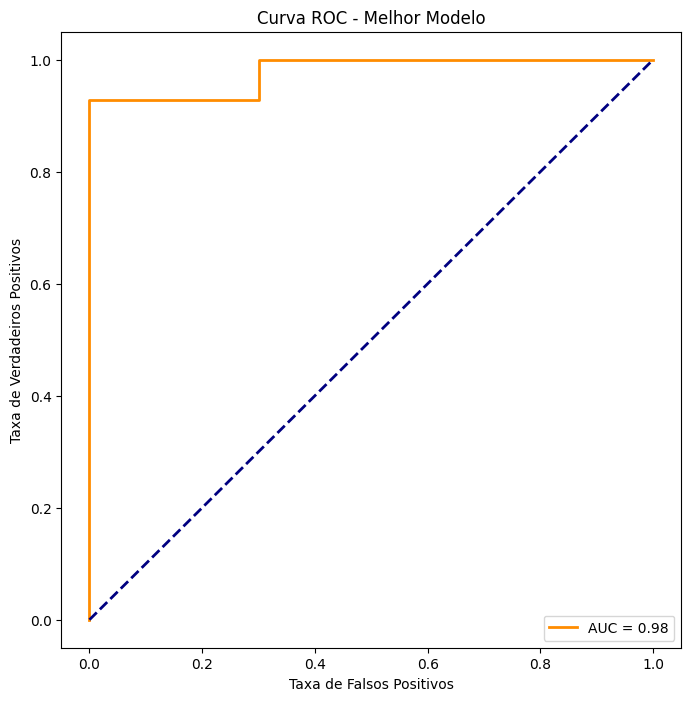

In [53]:
# Obtenha as probabilidades previstas para a classe positiva no conjunto de teste
y_prob = rf_model_best.predict_proba(X_test)[:, 1]

# Calcule a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcule a área sob a curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Melhor Modelo')
plt.legend(loc='lower right')
plt.show()

In [56]:
#AUC - 0.98

In [54]:
from sklearn.metrics import recall_score


In [55]:
recall = recall_score(y_test, rf_pred)
print("Recall RFB: {:.2f}".format(recall))

Recall RFB: 0.93


In [57]:
#0.93 Recall